## Prerequisites (Imports, Drive Mounting, Setting Working Directory, Saving Paths to Variables)

In [13]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
import cv2
import random
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
import gc
from keras import optimizers, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
import tqdm.notebook as tq
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from google.colab import output
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Changing working directory

%cd /content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData

/content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData


In [ ]:
traffic_class_labels = {0: '20 km/h',
1:'30 km/h',
2:'50 km/h',
3:'60 km/h',
4:'70 km/h',
5:'80 km/h',
6:'80 km/h end',
7:'100 km/h',
8:'120 km/h',
9:'No overtaking',
10:'No overtaking for trucks',
11:'Crossroad with secondary way',
12:'Main road',
13:'Give way',
14:'Stop',
15:'Road up',
16:'Road up for trucks',
17:'No Entry',
18:'Other dangerous',
19:'Turn left',
20:'Turn right',
21:'Winding road',
22:'Hollow road',
23:'Slippery road',
24:'Narrowing road',
25:'Roadwork',
26:'Traffic light',
27:'Pedestrian',
28:'Children',
29:'Cycle',
30:'Snow',
31:'Deer',
32:'End of the limits',
33:'Only right',
34:'Only left',
35:'Only straight',
36:'Only straight and right',
37:'Only straight and left',
38:'Take right',
39:'Take left',
40:'Circle crossroad',
41:'End of overtaking limit',
42:'End of overtaking limit for track'
}


In [ ]:
# Paths and parameters.
numpyarray_path = '../NumpyArrays'
train_data_path = '../NumpyArrays/Cells.npy'
train_label_path = '../NumpyArrays/Labels.npy'
test_data_path = '../NumpyArrays/Cells_test.npy'
test_blur3_path = '../NumpyArrays/Cells_test_blur3.npy'
test_blur5_path = '../NumpyArrays/Cells_test_blur5.npy'
test_blur7_path = '../NumpyArrays/Cells_test_blur7.npy'
test_label_path = '../NumpyArrays/Labels_test.npy'
visualization_path = '../Visualizations'

height = 75
width = 75
channels = 3
classes = 43
n_inputs = height*width*channels

class_labels = [traffic_class_labels[i] for i in range(len(traffic_class_labels))]

## One Time Tasks

### Copying data from Kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData"

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 601M/612M [00:18<00:00, 46.5MB/s]
100% 612M/612M [00:18<00:00, 35.3MB/s]


### Unzipping Kaggle data to Dataset folder.


In [ ]:
# Checking and removing the files present in Dataset folder before unzipping the new files.
# Take almost 11 mins.

%%time

while(os.path.isdir('../Dataset')):
  shutil.rmtree('../Dataset/', ignore_errors=True)

# def rmtree(directory):
#     for root, dirs, files in os.walk(directory, topdown=False):
#         for file in files:
#             os.remove(os.path.join(root, file))
#         for dir in dirs:
#             os.rmdir(os.path.join(root, dir))
#     os.rmdir(directory)

# rmtree('../Dataset/') if os.path.isdir('../Dataset/') else print("No Directory")

CPU times: user 1.26 s, sys: 1.17 s, total: 2.43 s
Wall time: 1min 32s


In [ ]:
# Unzipping kaggle files.
# Take almost 26 mins.

%%time
!unzip '/content/drive/My Drive/Colab Notebooks/Traffic Sign/KaggleData/gtsrb-german-traffic-sign.zip' -d '/content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset'


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00007.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00008.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00009.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00010.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00011.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00012.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00013.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_00010_00014.png  
  inflating: /content/drive/My Drive/Colab Notebooks/Traffic Sign/Dataset/train/34/00034_0001

### Train and Test Images are read, converted into array and saved arrays as .npy file.


In [ ]:
# Reading the input images and putting them into a numpy array

cells=[]
labels=[]

for i in range(classes):
    path = "../Dataset/Train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    bar = tq.tqdm(range(len(Class)))
    for j in bar:
        try:
            image=cv2.imread(path+Class[j])
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            cells.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
    if i!=classes-1:
      output.clear() 

../Dataset/Train/42/


Length of cells List:  39209
Length of labels List:  39209

1


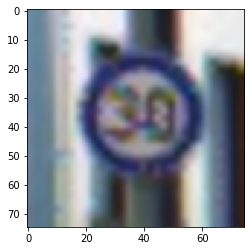

In [ ]:
print('Length of cells List: ',len(cells))
print('Length of labels List: ',len(labels))
print('')
print(labels[1020])
plt.imshow(cells[1020])

1


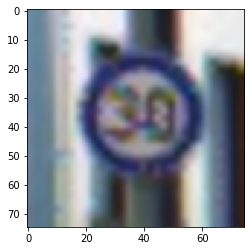

In [ ]:
# Converting lists into numpy arrays and verifying by printing a random image.

Cells=np.array(cells)
Labels=np.array(labels)

print(Labels[1020])
plt.imshow(Cells[1020])

In [ ]:
# If directory is not present, a new one is created. Arrays are saved in the directory

if not os.path.isdir(numpyarray_path): 
  os.mkdir(numpyarray_path)

np.save(train_data_path, Cells)
np.save(train_label_path, Labels)

In [ ]:
# Clearing memory.

del cells
del Cells
del labels
del Labels

gc.collect()

673

In [ ]:
pd.read_csv("../Dataset/Test.csv").head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [ ]:
# Loading test data.

y_test=pd.read_csv("../Dataset/Test.csv")
paths=y_test['Path']

cells=[]
labels=y_test['ClassId'].values

for f in tq.tqdm(range(len(paths))):
    # print(paths[f])
    image=cv2.imread('../Dataset/'+paths[f])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    cells.append(np.array(size_image))


Length of cells List:  12630
Length of labels List:  12630

35


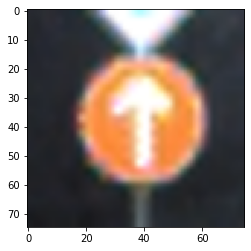

In [ ]:
print('Length of cells List: ',len(cells))
print('Length of labels List: ',len(labels))
print('')
print(labels[1100])
plt.imshow(cells[1100])

35


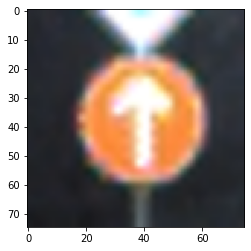

In [ ]:
# Converting lists into numpy arrays and verifying by printing a random image.

Cells=np.array(cells)
Labels=np.array(labels)

print(Labels[1100])
plt.imshow(Cells[1100])

In [ ]:
# Saving test data array to files.

np.save(test_data_path, Cells)
np.save(test_label_path, Labels)

In [ ]:
# Clearing memory.

del cells
del Cells
del labels
del Labels
del y_test
del paths

gc.collect()

284

### Test images are blurred in three levels and saved in numpy arrays.

In [ ]:
# Read test images, blur them at 3X3, 5X5, and 7X7 levels.
# Append the images to the respective lists.

y_test=pd.read_csv("../Dataset/Test.csv")
paths=y_test['Path']

cells_3 = []
cells_5 = []
cells_7 = []
labels=y_test['ClassId'].values

for f in tq.tqdm(range(len(paths))):
    # print(paths[f])
    image=cv2.imread('../Dataset/'+paths[f])

    blurred_image_3 = cv2.GaussianBlur(image, (3,3), cv2.BORDER_DEFAULT)
    image_from_array_3 = Image.fromarray(blurred_image_3, 'RGB')
    resize_image_3 = image_from_array_3.resize((height, width))
    cells_3.append(np.array(resize_image_3))

    blurred_image_5 = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT)
    image_from_array_5 = Image.fromarray(blurred_image_5, 'RGB')
    resize_image_5 = image_from_array_5.resize((height, width))
    cells_5.append(np.array(resize_image_5))

    blurred_image_7 = cv2.GaussianBlur(image, (7,7), cv2.BORDER_DEFAULT)
    image_from_array_7 = Image.fromarray(blurred_image_7, 'RGB')
    resize_image_7 = image_from_array_7.resize((height, width))
    cells_7.append(np.array(resize_image_7))

In [ ]:
# Converting test data to arrays.

Cells_3 = np.array(cells_3)
Cells_5 = np.array(cells_5)
Cells_7 = np.array(cells_7)

1


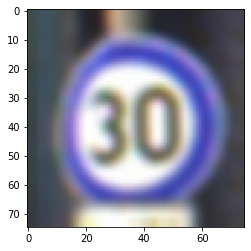

In [ ]:
# Blur level 3.

print(labels[1])
plt.imshow(Cells_3[1])

1


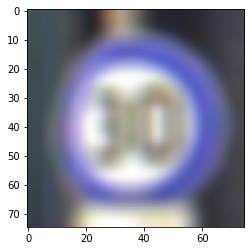

In [ ]:
# Blur level 5.

print(labels[1])
plt.imshow(Cells_5[1])

1


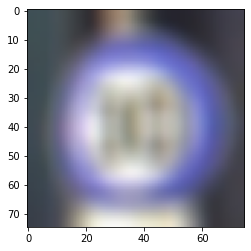

In [ ]:
# Blur level 7.

print(labels[1])
plt.imshow(Cells_7[1])

In [ ]:
# Saving test data array to files.

np.save(test_blur3_path, Cells_3)
np.save(test_blur5_path, Cells_5)
np.save(test_blur7_path, Cells_7)

In [ ]:
# Clearing memory.

del labels
del cells_3
del cells_5
del cells_7
del Cells_3
del Cells_5
del Cells_7
del paths
del y_test

gc.collect()

## Read Numpy arrays from saved files and divided in Train, Validation, and Test sets.


In [ ]:
# Loading Train Data.

Cells = np.load(train_data_path)
labels = np.load(train_label_path)

In [ ]:
# Randomize the order of the input images

s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [ ]:
# Spliting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]

X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

In [ ]:
# Using one hote encoding for the train and validation labels

y_train = to_categorical(y_train, classes)
y_val = to_categorical(y_val, classes)

In [ ]:
# Loading test data from saved array files.

X_test = np.load(test_data_path)
X_test_3 = np.load(test_blur3_path)
X_test_5 = np.load(test_blur5_path)
X_test_7 = np.load(test_blur7_path)
y_test = np.load(test_label_path)

1


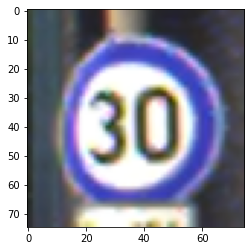

In [ ]:
# Original Image.

print(y_test[1])
plt.imshow(X_test[1])

1


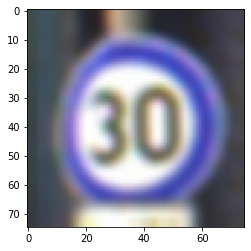

In [ ]:
# Image blurred at level 3.

print(y_test[1])
plt.imshow(X_test_3[1])

1


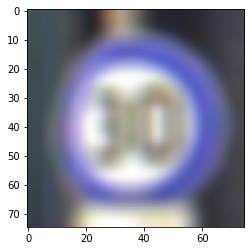

In [ ]:
# Image blurred at level 5.

print(y_test[1])
plt.imshow(X_test_5[1])

1


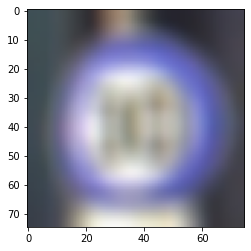

In [ ]:
# Image blurred at level 7.

print(y_test[1])
plt.imshow(X_test_7[1])

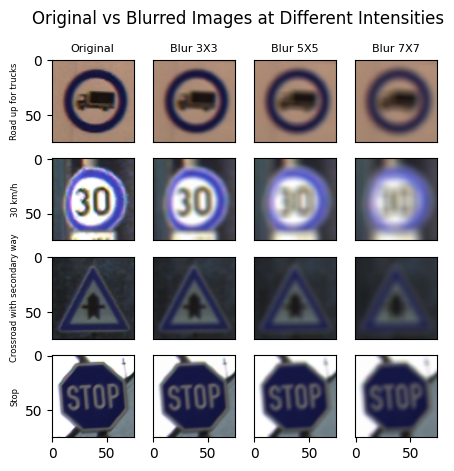

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(5, 5), dpi=100)

fig.suptitle("Original vs Blurred Images at Different Intensities", fontdict = {'fontsize': 10, 'fontweight' : 3})

ax[0,0].set_title("Original", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,0].imshow(X_test[0])
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].set_ylabel(traffic_class_labels[y_test[0]], fontdict = {'fontsize': 6, 'fontweight' : 3})

ax[0,1].set_title("Blur 3X3", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,1].imshow(X_test_3[0])
ax[0,1].get_yaxis().set_visible(False)
ax[0,1].get_xaxis().set_visible(False)

ax[0,2].set_title("Blur 5X5", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,2].imshow(X_test_5[0])
ax[0,2].get_yaxis().set_visible(False)
ax[0,2].get_xaxis().set_visible(False)

ax[0,3].set_title("Blur 7X7", fontdict = {'fontsize': 8, 'fontweight' : 3})
ax[0,3].imshow(X_test_7[0])
ax[0,3].get_yaxis().set_visible(False)
ax[0,3].get_xaxis().set_visible(False)

# ax[1,0].set_title("Original")
ax[1,0].imshow(X_test[1])
ax[1,0].get_xaxis().set_visible(False)
ax[1,0].set_ylabel(traffic_class_labels[y_test[1]], fontdict = {'fontsize': 6, 'fontweight' : 3})
   
# ax[1,1].set_title("Blur 3X3")
ax[1,1].imshow(X_test_3[1])
ax[1,1].get_yaxis().set_visible(False)
ax[1,1].get_xaxis().set_visible(False)
   
# ax[1,2].set_title("Blur 5X5")
ax[1,2].imshow(X_test_5[1])
ax[1,2].get_yaxis().set_visible(False)
ax[1,2].get_xaxis().set_visible(False)
   
# ax[1,3].set_title("Blur 7X7")
ax[1,3].imshow(X_test_7[1])
ax[1,3].get_yaxis().set_visible(False)
ax[1,3].get_xaxis().set_visible(False)

# ax[2,0].set_title("Original")
ax[2,0].imshow(X_test[4])
ax[2,0].get_xaxis().set_visible(False)
ax[2,0].set_ylabel(traffic_class_labels[y_test[4]], fontdict = {'fontsize': 6, 'fontweight' : 3})
   
# ax[2,1].set_title("Blur 3X3")
ax[2,1].imshow(X_test_3[4])
ax[2,1].get_yaxis().set_visible(False)
ax[2,1].get_xaxis().set_visible(False)
   
# ax[2,2].set_title("Blur 5X5")
ax[2,2].imshow(X_test_5[4])
ax[2,2].get_yaxis().set_visible(False)
ax[2,2].get_xaxis().set_visible(False)
   
# ax[2,3].set_title("Blur 7X7")
ax[2,3].imshow(X_test_7[4])
ax[2,3].get_yaxis().set_visible(False)
ax[2,3].get_xaxis().set_visible(False)

# ax[3,0].set_title("Original")
ax[3,0].imshow(X_test[93])
ax[3,0].set_ylabel(traffic_class_labels[y_test[93]], fontdict = {'fontsize': 6, 'fontweight' : 3})
   
# ax[3,1].set_title("Blur 3X3")
ax[3,1].imshow(X_test_3[93])
ax[3,1].get_yaxis().set_visible(False)
   
# ax[3,2].set_title("Blur 5X5")
ax[3,2].imshow(X_test_5[93])
ax[3,2].get_yaxis().set_visible(False)
   
# ax[3,3].set_title("Blur 7X7")
ax[3,3].imshow(X_test_7[93])
ax[3,3].get_yaxis().set_visible(False)

fig.savefig(os.path.join(visualization_path, 'original_vs_blurred.png'), dpi=300, bbox_inches='tight')

In [ ]:
X_test = X_test.astype('float32')/255 
X_test_3 = X_test_3.astype('float32')/255 
X_test_5 = X_test_5.astype('float32')/255 
X_test_7 = X_test_7.astype('float32')/255 

## Self-designed CNN model (Accuracy 97%)

In [ ]:
# Definition of the CNN model

self_model = Sequential()
self_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
self_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
self_model.add(MaxPool2D(pool_size=(2, 2)))
self_model.add(Dropout(rate=0.25))
self_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
self_model.add(MaxPool2D(pool_size=(2, 2)))
self_model.add(Dropout(rate=0.25))
self_model.add(Flatten())
self_model.add(Dense(256, activation='relu'))
self_model.add(Dropout(rate=0.5))
self_model.add(Dense(43, activation='softmax'))

In [ ]:
#Compilation of the model

self_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [ ]:
#using ten epochs for the training and saving the accuracy for each epoch

self_epochs = 20
self_batch_size = 32

start_time = time.time()

self_history = self_model.fit(X_train, y_train, batch_size=self_batch_size, epochs=self_epochs,
validation_data=(X_val, y_val))

self_training_time = time.time()-start_time

Train on 31368 samples, validate on 7841 samples
Epoch 1/20
31368/31368 [==============================] - 21s 676us/step - loss: 1.1979 - accuracy: 0.6632 - val_loss: 0.1804 - val_accuracy: 0.9561
Epoch 2/20
31368/31368 [==============================] - 21s 673us/step - loss: 0.2723 - accuracy: 0.9167 - val_loss: 0.0836 - val_accuracy: 0.9786
Epoch 3/20
31368/31368 [==============================] - 21s 661us/step - loss: 0.1732 - accuracy: 0.9467 - val_loss: 0.0709 - val_accuracy: 0.9801
Epoch 4/20
31368/31368 [==============================] - 21s 662us/step - loss: 0.1302 - accuracy: 0.9589 - val_loss: 0.0590 - val_accuracy: 0.9853
Epoch 5/20
31368/31368 [==============================] - 21s 664us/step - loss: 0.1042 - accuracy: 0.9663 - val_loss: 0.0364 - val_accuracy: 0.9901
Epoch 6/20
31368/31368 [==============================] - 21s 672us/step - loss: 0.0865 - accuracy: 0.9715 - val_loss: 0.0324 - val_accuracy: 0.9927
Epoch 7/20
31368/31368 [==============================] -

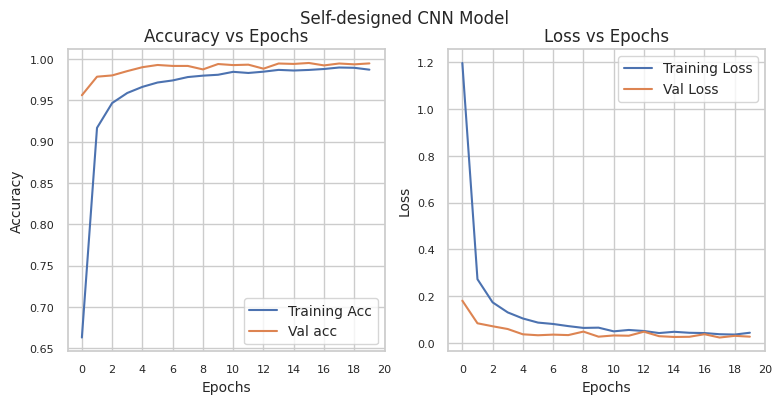

In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)


fig.suptitle("Self-designed CNN Model", fontdict = {'fontsize': 10, 'fontweight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(self_history.history['accuracy'], label='Training Acc')
ax[0].plot(self_history.history['val_accuracy'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(self_history.history['loss'], label='Training Loss')
ax[1].plot(self_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))

fig.savefig(os.path.join(visualization_path, 'self_acc_loss.png'), dpi=300, bbox_inches='tight')

In [ ]:
# # Creating plots


# plt.figure(0)
# plt.plot(self_history.history['accuracy'], label='training accuracy')
# plt.plot(self_history.history['val_accuracy'], label='val accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.figure(1)
# plt.plot(self_history.history['loss'], label='training loss')
# plt.plot(self_history.history['val_loss'], label='val loss')
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

In [ ]:
# Predicting output.

self_pred = self_model.predict_classes(X_test)
self_pred_3 = self_model.predict_classes(X_test_3)
self_pred_5 = self_model.predict_classes(X_test_5)
self_pred_7 = self_model.predict_classes(X_test_7)

In [ ]:
# Prediction accuracy of Original Images.

self_acc_original = accuracy_score(y_test, self_pred)
self_acc_original

0.9429136975455266

In [ ]:
# Prediction accuracy with images blurred at level 3.

self_acc_3 = accuracy_score(y_test, self_pred_3)
self_acc_3

0.8827395091053049

In [ ]:
# Prediction accuracy with images blurred at level 5.

self_acc_5 = accuracy_score(y_test, self_pred_5)
self_acc_5

0.7110055423594616

In [ ]:
# Prediction accuracy with images blurred at level 7.

self_acc_7 = accuracy_score(y_test, self_pred_7)
self_acc_7

0.5574821852731592

In [ ]:
self_class_report = classification_report(y_test, self_pred, target_names = class_labels, output_dict=True)
print(self_class_report)

{'20 km/h': {'precision': 0.84375, 'recall': 0.9, 'f1-score': 0.870967741935484, 'support': 60}, '30 km/h': {'precision': 0.9573590096286108, 'recall': 0.9666666666666667, 'f1-score': 0.9619903248099516, 'support': 720}, '50 km/h': {'precision': 0.8553386911595867, 'recall': 0.9933333333333333, 'f1-score': 0.919185687847008, 'support': 750}, '60 km/h': {'precision': 0.9292929292929293, 'recall': 0.8177777777777778, 'f1-score': 0.8699763593380615, 'support': 450}, '70 km/h': {'precision': 0.9773071104387292, 'recall': 0.9787878787878788, 'f1-score': 0.9780469341408025, 'support': 660}, '80 km/h': {'precision': 0.8788819875776398, 'recall': 0.8984126984126984, 'f1-score': 0.8885400313971743, 'support': 630}, '80 km/h end': {'precision': 0.9913793103448276, 'recall': 0.7666666666666667, 'f1-score': 0.8646616541353382, 'support': 150}, '100 km/h': {'precision': 0.9530864197530864, 'recall': 0.8577777777777778, 'f1-score': 0.9029239766081871, 'support': 450}, '120 km/h': {'precision': 0.943

In [ ]:
self_class_report_3 = classification_report(y_test, self_pred_3, target_names = class_labels)
print(self_class_report_3)

                                   precision    recall  f1-score   support

                          20 km/h       0.90      0.72      0.80        60
                          30 km/h       0.90      0.89      0.90       720
                          50 km/h       0.81      0.92      0.86       750
                          60 km/h       0.81      0.56      0.66       450
                          70 km/h       0.94      0.94      0.94       660
                          80 km/h       0.73      0.78      0.75       630
                      80 km/h end       0.96      0.46      0.62       150
                         100 km/h       0.75      0.83      0.79       450
                         120 km/h       0.83      0.73      0.78       450
                    No overtaking       0.98      0.93      0.95       480
         No overtaking for trucks       0.98      0.91      0.94       660
     Crossroad with secondary way       0.92      0.93      0.92       420
                        

In [ ]:
self_class_report_5 = classification_report(y_test, self_pred_5, target_names = class_labels)
print(self_class_report_5)

                                   precision    recall  f1-score   support

                          20 km/h       0.81      0.28      0.42        60
                          30 km/h       0.77      0.63      0.69       720
                          50 km/h       0.66      0.71      0.68       750
                          60 km/h       0.56      0.26      0.36       450
                          70 km/h       0.86      0.61      0.71       660
                          80 km/h       0.43      0.56      0.49       630
                      80 km/h end       0.80      0.21      0.34       150
                         100 km/h       0.48      0.63      0.54       450
                         120 km/h       0.42      0.43      0.42       450
                    No overtaking       0.90      0.58      0.71       480
         No overtaking for trucks       0.93      0.72      0.81       660
     Crossroad with secondary way       0.80      0.85      0.82       420
                        

In [ ]:
self_class_report_7 = classification_report(y_test, self_pred_7, target_names = class_labels)
print(self_class_report_7)

                                   precision    recall  f1-score   support

                          20 km/h       0.50      0.15      0.23        60
                          30 km/h       0.64      0.41      0.50       720
                          50 km/h       0.46      0.52      0.49       750
                          60 km/h       0.49      0.17      0.26       450
                          70 km/h       0.85      0.29      0.44       660
                          80 km/h       0.27      0.40      0.32       630
                      80 km/h end       0.66      0.13      0.21       150
                         100 km/h       0.33      0.43      0.38       450
                         120 km/h       0.20      0.27      0.23       450
                    No overtaking       0.66      0.33      0.44       480
         No overtaking for trucks       0.86      0.46      0.60       660
     Crossroad with secondary way       0.73      0.72      0.72       420
                        

## ResNet50 (Accuracy 97%)

In [ ]:
# Load the pre-trained model.

resnet_pretrained_model=ResNet50(input_shape=(height,width,channels),
                                  include_top=False,
                                  weights=None
                                   )

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
# Created a classifier layer.

resnet_x = resnet_pretrained_model.output
resnet_x = GlobalAveragePooling2D()(resnet_x)
resnet_x = Dropout(0.5)(resnet_x)
resnet_predictions = Dense(classes, activation= 'softmax')(resnet_x)

In [ ]:
# Created model by combining Feature layer from pre-trained model and newly created Classifier layer.

resnet_model = Model(inputs = resnet_pretrained_model.input, outputs = resnet_predictions)

In [ ]:
resnet_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:

model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(31368, 75, 75, 3)
(7841, 75, 75, 3)
(31368, 43)
(7841, 43)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(12630, 75, 75, 3)
(12630,)


In [ ]:
resnet_epochs = 20
resnet_batch_size = 32

start_time = time.time()

resnet_history =  resnet_model.fit(X_train, y_train,  batch_size = resnet_batch_size, epochs = resnet_epochs, verbose = 1, 
              validation_data = (X_val, y_val), callbacks = [model_check, early, reduce_lr, csv_logger])

resnet_training_time = time.time()-start_time

Train on 31368 samples, validate on 7841 samples
Epoch 1/20
31368/31368 [==============================] - 152s 5ms/step - loss: 2.0712 - accuracy: 0.4861 - val_loss: 0.5288 - val_accuracy: 0.8413
Epoch 2/20
31368/31368 [==============================] - 137s 4ms/step - loss: 0.2295 - accuracy: 0.9319 - val_loss: 0.1059 - val_accuracy: 0.9674
Epoch 3/20
31368/31368 [==============================] - 137s 4ms/step - loss: 0.1120 - accuracy: 0.9671 - val_loss: 0.1661 - val_accuracy: 0.9529
Epoch 4/20
31368/31368 [==============================] - 137s 4ms/step - loss: 0.0915 - accuracy: 0.9733 - val_loss: 0.1278 - val_accuracy: 0.9638
Epoch 5/20
31368/31368 [==============================] - 137s 4ms/step - loss: 0.0751 - accuracy: 0.9788 - val_loss: 0.0879 - val_accuracy: 0.9760
Epoch 6/20
31368/31368 [==============================] - 137s 4ms/step - loss: 0.0691 - accuracy: 0.9813 - val_loss: 0.0905 - val_accuracy: 0.9732
Epoch 7/20
31368/31368 [==============================] - 138s 

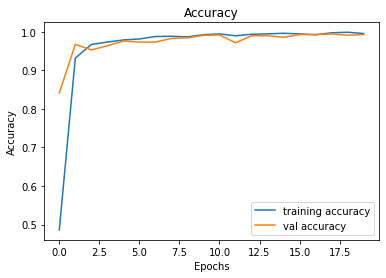

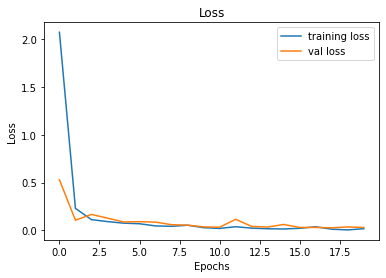

In [ ]:
# Creating plots
 
plt.figure(0)
plt.plot(resnet_history.history['accuracy'], label='training accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.figure(1)
plt.plot(resnet_history.history['loss'], label='training loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Predicting output.
 
resnet_pred = resnet_model.predict(X_test)
resnet_pred_3 = resnet_model.predict(X_test_3)
resnet_pred_5 = resnet_model.predict(X_test_5)
resnet_pred_7 = resnet_model.predict(X_test_7)
print(resnet_pred.shape)

(12630, 43)


In [ ]:
resnet_pred = np.argmax(resnet_pred, axis=1)
resnet_pred_3 = np.argmax(resnet_pred_3, axis=1)
resnet_pred_5 = np.argmax(resnet_pred_5, axis=1)
resnet_pred_7 = np.argmax(resnet_pred_7, axis=1)

In [ ]:
# Prediction accuracy of Original Images.

resnet_acc_original = accuracy_score(y_test, resnet_pred)
resnet_acc_original

0.964528899445764

In [ ]:
# Classification Report
 
print(classification_report(y_test, resnet_pred, target_names=class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.88      0.97      0.92        60
                          30 km/h       0.95      0.99      0.97       720
                          50 km/h       0.99      1.00      0.99       750
                          60 km/h       0.96      0.99      0.98       450
                          70 km/h       0.99      0.97      0.98       660
                          80 km/h       0.96      0.98      0.97       630
                      80 km/h end       1.00      0.84      0.91       150
                         100 km/h       0.98      0.92      0.95       450
                         120 km/h       0.93      0.95      0.94       450
                    No overtaking       0.97      1.00      0.98       480
         No overtaking for trucks       1.00      0.99      0.99       660
     Crossroad with secondary way       0.91      0.93      0.92       420
                        

In [ ]:
# Prediction accuracy with images blurred at level 3.

resnet_acc_3 = accuracy_score(y_test, resnet_pred_3)
resnet_acc_3

0.9403800475059383

In [ ]:
# Prediction accuracy with images blurred at level 5.

resnet_acc_5 = accuracy_score(y_test, resnet_pred_5)
resnet_acc_5

0.8344418052256533

In [ ]:
# Prediction accuracy with images blurred at level 7.

resnet_acc_7 = accuracy_score(y_test, resnet_pred_7)
resnet_acc_7

0.6906571654790182

## Inception (Accuracy 81%)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [ ]:
#Load the InceptionV3 model

inception_pretrained_model = InceptionV3(input_shape = (75, 75, 3), 
                        include_top = False, 
                        weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception_pretrained_model.layers:
     layer.trainable = False

In [ ]:
# inception_pretrained_model.summary()
inception_last_layer = inception_pretrained_model.get_layer('mixed7')
print('last layer output shape: ', inception_last_layer.output_shape)
inception_last_output = inception_last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [ ]:
inception_x = layers.Flatten()(inception_last_output)
inception_x = layers.Dense(1024, activation='relu')(inception_x)
inception_x = layers.Dropout(0.2)(inception_x)                  
inception_x = layers.Dense(classes, activation='softmax')(inception_x)

In [ ]:
inception_model = Model(inception_pretrained_model.input, inception_x) 

In [ ]:
inception_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [ ]:
# Using twenty epochs for the training and saving the accuracy for each epoch

inception_epochs = 20
inception_batch_size = 32

start_time = time.time()

inception_history = inception_model.fit(X_train, y_train, batch_size=inception_batch_size, 
                        epochs=inception_epochs, validation_data = (X_val, y_val))

inception_training_time = time.time()-start_time

Epoch 1/20
981/981 [==============================] - 18s 18ms/step - loss: 0.7829 - acc: 0.7678 - val_loss: 0.4146 - val_acc: 0.8623
Epoch 2/20
981/981 [==============================] - 16s 17ms/step - loss: 0.2327 - acc: 0.9284 - val_loss: 0.2410 - val_acc: 0.9234
Epoch 3/20
981/981 [==============================] - 16s 17ms/step - loss: 0.1293 - acc: 0.9605 - val_loss: 0.1592 - val_acc: 0.9482
Epoch 4/20
981/981 [==============================] - 16s 17ms/step - loss: 0.0829 - acc: 0.9749 - val_loss: 0.1365 - val_acc: 0.9555
Epoch 5/20
981/981 [==============================] - 16s 17ms/step - loss: 0.0579 - acc: 0.9825 - val_loss: 0.1174 - val_acc: 0.9611
Epoch 6/20
981/981 [==============================] - 17s 17ms/step - loss: 0.0421 - acc: 0.9876 - val_loss: 0.1045 - val_acc: 0.9695
Epoch 7/20
981/981 [==============================] - 17s 17ms/step - loss: 0.0319 - acc: 0.9901 - val_loss: 0.0895 - val_acc: 0.9726
Epoch 8/20
981/981 [==============================] - 16s 17ms

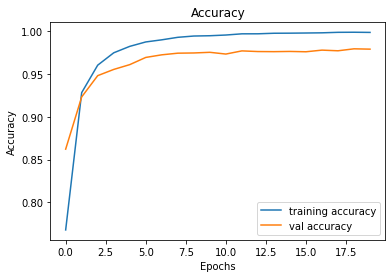

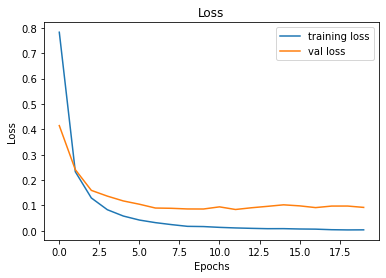

In [ ]:
# Creating plots

plt.figure(0)
plt.plot(inception_history.history['acc'], label='training accuracy')
plt.plot(inception_history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(1)
plt.plot(inception_history.history['loss'], label='training loss')
plt.plot(inception_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Predicting output.

inception_pred = inception_model.predict(X_test)
inception_pred_3 = inception_model.predict(X_test_3)
inception_pred_5 = inception_model.predict(X_test_5)
inception_pred_7 = inception_model.predict(X_test_7)

In [ ]:
inception_acc_original = accuracy_score(y_test, np.argmax(inception_pred, axis=1))
inception_acc_original

In [ ]:
inception_acc_3 = accuracy_score(y_test, np.argmax(inception_pred_3, axis=1))
inception_acc_3

In [ ]:
inception_acc_5 = accuracy_score(y_test, np.argmax(inception_pred_5, axis=1))
inception_acc_5

In [ ]:
inception_acc_7 = accuracy_score(y_test, np.argmax(inception_pred_7, axis=1))
inception_acc_7

In [ ]:
print(classification_report(y_test, np.argmax(inception_pred, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.58      0.32      0.41        60
                          30 km/h       0.78      0.82      0.80       720
                          50 km/h       0.65      0.67      0.66       750
                          60 km/h       0.70      0.50      0.59       450
                          70 km/h       0.78      0.79      0.79       660
                          80 km/h       0.71      0.73      0.72       630
                      80 km/h end       0.95      0.84      0.89       150
                         100 km/h       0.81      0.83      0.82       450
                         120 km/h       0.69      0.80      0.74       450
                    No overtaking       0.92      0.96      0.94       480
         No overtaking for trucks       0.93      0.97      0.95       660
     Crossroad with secondary way       0.80      0.71      0.75       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(inception_pred_3, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.38      0.05      0.09        60
                          30 km/h       0.71      0.68      0.70       720
                          50 km/h       0.63      0.57      0.60       750
                          60 km/h       0.65      0.40      0.49       450
                          70 km/h       0.80      0.52      0.63       660
                          80 km/h       0.53      0.65      0.59       630
                      80 km/h end       0.79      0.61      0.69       150
                         100 km/h       0.57      0.57      0.57       450
                         120 km/h       0.40      0.72      0.52       450
                    No overtaking       0.94      0.70      0.81       480
         No overtaking for trucks       0.57      0.95      0.71       660
     Crossroad with secondary way       0.64      0.66      0.65       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(inception_pred_5, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.00      0.00      0.00        60
                          30 km/h       0.67      0.49      0.57       720
                          50 km/h       0.54      0.41      0.47       750
                          60 km/h       0.34      0.23      0.27       450
                          70 km/h       0.70      0.20      0.31       660
                          80 km/h       0.36      0.62      0.45       630
                      80 km/h end       0.31      0.27      0.29       150
                         100 km/h       0.34      0.38      0.36       450
                         120 km/h       0.23      0.59      0.33       450
                    No overtaking       0.95      0.41      0.57       480
         No overtaking for trucks       0.36      0.84      0.51       660
     Crossroad with secondary way       0.57      0.66      0.61       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(inception_pred_7, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.00      0.00      0.00        60
                          30 km/h       0.65      0.32      0.43       720
                          50 km/h       0.47      0.31      0.37       750
                          60 km/h       0.15      0.17      0.16       450
                          70 km/h       0.45      0.08      0.14       660
                          80 km/h       0.27      0.58      0.37       630
                      80 km/h end       0.30      0.17      0.21       150
                         100 km/h       0.25      0.24      0.25       450
                         120 km/h       0.15      0.50      0.24       450
                    No overtaking       0.95      0.22      0.36       480
         No overtaking for trucks       0.24      0.70      0.36       660
     Crossroad with secondary way       0.48      0.59      0.53       420
                        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## VGG16 (Accuracy 73%)

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop

In [ ]:
#Load the VGG19 model
vgg16_pretrained_model = VGG16(input_shape = (width, height, channels), 
                        include_top = False, 
                        weights = 'imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg16_pretrained_model.layers:
     layer.trainable = False

In [ ]:
# vgg_model.summary()
vgg16_last_layer = vgg16_pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', vgg16_last_layer.output_shape)
vgg16_last_output= vgg16_last_layer.output

last layer of vgg : output shape:  (None, 2, 2, 512)


In [ ]:
vgg16_x = layers.Flatten()(vgg16_last_output)
vgg16_x = layers.Dense(1024, activation='relu')(vgg16_x)
vgg16_x = layers.Dropout(0.2)(vgg16_x)                  
vgg16_x = layers.Dense(43, activation='softmax')(vgg16_x)   

In [ ]:
vgg16_model = Model(vgg16_pretrained_model.input, vgg16_x) 

In [ ]:
vgg16_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [ ]:
#using twenty epochs for the training and saving the accuracy for each epoch


vgg16_epochs = 20
vgg16_batch_size = 32

start_time = time.time()

vgg16_history = vgg16_model.fit(X_train, y_train, batch_size=vgg16_batch_size, 
                        epochs=vgg16_epochs, validation_data = (X_val, y_val))

vgg16_training_time = time.time()-start_time

Epoch 1/20
981/981 [==============================] - 33s 33ms/step - loss: 1.7119 - acc: 0.5170 - val_loss: 1.1635 - val_acc: 0.6602
Epoch 2/20
981/981 [==============================] - 33s 33ms/step - loss: 0.9879 - acc: 0.7076 - val_loss: 0.8492 - val_acc: 0.7536
Epoch 3/20
981/981 [==============================] - 33s 33ms/step - loss: 0.7372 - acc: 0.7872 - val_loss: 0.6780 - val_acc: 0.8060
Epoch 4/20
981/981 [==============================] - 33s 33ms/step - loss: 0.5879 - acc: 0.8312 - val_loss: 0.5456 - val_acc: 0.8479
Epoch 5/20
981/981 [==============================] - 33s 33ms/step - loss: 0.4902 - acc: 0.8607 - val_loss: 0.4711 - val_acc: 0.8647
Epoch 6/20
981/981 [==============================] - 33s 33ms/step - loss: 0.4179 - acc: 0.8804 - val_loss: 0.4238 - val_acc: 0.8730
Epoch 7/20
981/981 [==============================] - 33s 33ms/step - loss: 0.3627 - acc: 0.8953 - val_loss: 0.3647 - val_acc: 0.8947
Epoch 8/20
981/981 [==============================] - 33s 33ms

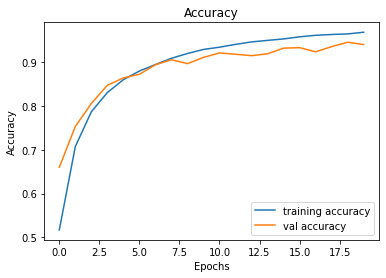

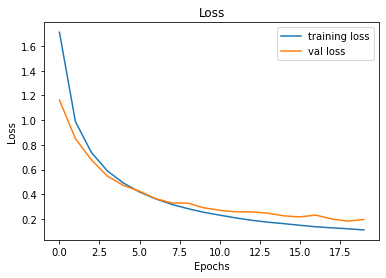

In [ ]:
# Creating plots

plt.figure(0)
plt.plot(vgg16_history.history['acc'], label='training accuracy')
plt.plot(vgg16_history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(1)
plt.plot(vgg16_history.history['loss'], label='training loss')
plt.plot(vgg16_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Predicting output.

vgg16_pred = vgg16_model.predict(X_test)
# print(vgg16_pred.shape)
vgg16_pred_3 = vgg16_model.predict(X_test_3)
vgg16_pred_5 = vgg16_model.predict(X_test_5)
vgg16_pred_7 = vgg16_model.predict(X_test_7)

In [ ]:
vgg16_acc_original = accuracy_score(y_test, np.argmax(vgg16_pred, axis=1))
vgg16_acc_original

In [ ]:
vgg16_acc_3 = accuracy_score(y_test, np.argmax(vgg16_pred_3, axis=1))
vgg16_acc_3

In [ ]:
vgg16_acc_5 = accuracy_score(y_test, np.argmax(vgg16_pred_5, axis=1))
vgg16_acc_5

In [ ]:
vgg16_acc_7 = accuracy_score(y_test, np.argmax(vgg16_pred_7, axis=1))
vgg16_acc_7

In [ ]:
print(classification_report(y_test, np.argmax(vgg16_pred, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.55      0.37      0.44        60
                          30 km/h       0.68      0.83      0.75       720
                          50 km/h       0.62      0.62      0.62       750
                          60 km/h       0.42      0.61      0.49       450
                          70 km/h       0.72      0.58      0.64       660
                          80 km/h       0.59      0.70      0.64       630
                      80 km/h end       0.85      0.74      0.79       150
                         100 km/h       0.75      0.83      0.79       450
                         120 km/h       0.84      0.50      0.63       450
                    No overtaking       0.94      0.69      0.79       480
         No overtaking for trucks       0.72      0.82      0.77       660
     Crossroad with secondary way       0.53      0.73      0.62       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(vgg16_pred_3, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.42      0.08      0.14        60
                          30 km/h       0.63      0.68      0.66       720
                          50 km/h       0.56      0.27      0.36       750
                          60 km/h       0.25      0.48      0.33       450
                          70 km/h       0.76      0.36      0.49       660
                          80 km/h       0.43      0.60      0.50       630
                      80 km/h end       0.52      0.66      0.58       150
                         100 km/h       0.53      0.62      0.57       450
                         120 km/h       0.56      0.28      0.38       450
                    No overtaking       0.85      0.40      0.55       480
         No overtaking for trucks       0.39      0.78      0.52       660
     Crossroad with secondary way       0.38      0.76      0.51       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(vgg16_pred_5, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.67      0.03      0.06        60
                          30 km/h       0.60      0.49      0.54       720
                          50 km/h       0.67      0.09      0.16       750
                          60 km/h       0.10      0.31      0.15       450
                          70 km/h       0.80      0.10      0.18       660
                          80 km/h       0.29      0.57      0.39       630
                      80 km/h end       0.25      0.41      0.31       150
                         100 km/h       0.41      0.30      0.35       450
                         120 km/h       0.28      0.12      0.16       450
                    No overtaking       0.66      0.20      0.31       480
         No overtaking for trucks       0.26      0.58      0.36       660
     Crossroad with secondary way       0.29      0.90      0.44       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(vgg16_pred_7, axis=1), 
                            target_names = class_labels)) 

                                   precision    recall  f1-score   support

                          20 km/h       0.00      0.00      0.00        60
                          30 km/h       0.56      0.34      0.42       720
                          50 km/h       0.62      0.04      0.08       750
                          60 km/h       0.07      0.34      0.11       450
                          70 km/h       0.85      0.05      0.09       660
                          80 km/h       0.27      0.43      0.33       630
                      80 km/h end       0.17      0.32      0.22       150
                         100 km/h       0.32      0.17      0.22       450
                         120 km/h       0.18      0.05      0.08       450
                    No overtaking       0.47      0.14      0.21       480
         No overtaking for trucks       0.19      0.38      0.25       660
     Crossroad with secondary way       0.25      0.88      0.39       420
                        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## VGG19 (Accuracy 69%)

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import RMSprop

In [ ]:
#Load the VGG19 model
vgg19_pretrained_model = VGG19(input_shape = (width, height, 3), 
                        include_top = False, 
                        weights = 'imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg19_pretrained_model.layers:
     layer.trainable = False

In [ ]:
# vgg_model.summary()
vgg19_last_layer = vgg19_pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', vgg19_last_layer.output_shape)
vgg19_last_output = vgg19_last_layer.output

last layer of vgg : output shape:  (None, 2, 2, 512)


In [ ]:
vgg19_x = layers.Flatten()(vgg19_last_output)
vgg19_x = layers.Dense(1024, activation='relu')(vgg19_x)
vgg19_x = layers.Dropout(0.2)(vgg19_x)                  
vgg19_x = layers.Dense(classes, activation='softmax')(vgg19_x)    

In [ ]:
vgg19_model = Model(vgg19_pretrained_model.input, vgg19_x) 

In [ ]:
vgg19_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [ ]:
#using ten epochs for the training and saving the accuracy for each epoch

epochs = 20
vgg19_batch_size=32

start_time = time.time()

vgg19_history = vgg19_model.fit(X_train, y_train, batch_size=vgg19_batch_size, 
                        epochs=epochs, validation_data = (X_val, y_val))

vgg19_training_time = time.time()-start_time

Epoch 1/20
981/981 [==============================] - 39s 40ms/step - loss: 1.8809 - acc: 0.4727 - val_loss: 1.3777 - val_acc: 0.5749
Epoch 2/20
981/981 [==============================] - 39s 40ms/step - loss: 1.1863 - acc: 0.6511 - val_loss: 1.0341 - val_acc: 0.6946
Epoch 3/20
981/981 [==============================] - 39s 40ms/step - loss: 0.9350 - acc: 0.7246 - val_loss: 1.0077 - val_acc: 0.6744
Epoch 4/20
981/981 [==============================] - 39s 40ms/step - loss: 0.7832 - acc: 0.7691 - val_loss: 0.7794 - val_acc: 0.7541
Epoch 5/20
981/981 [==============================] - 39s 40ms/step - loss: 0.6802 - acc: 0.7997 - val_loss: 0.6996 - val_acc: 0.7764
Epoch 6/20
981/981 [==============================] - 39s 40ms/step - loss: 0.5998 - acc: 0.8228 - val_loss: 0.6114 - val_acc: 0.8199
Epoch 7/20
981/981 [==============================] - 39s 40ms/step - loss: 0.5409 - acc: 0.8400 - val_loss: 0.5698 - val_acc: 0.8299
Epoch 8/20
981/981 [==============================] - 39s 40ms

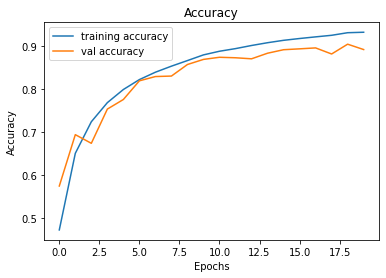

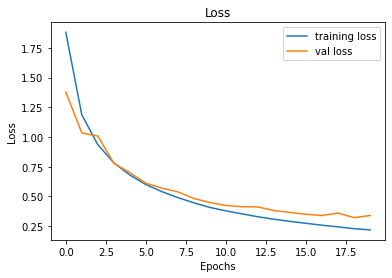

In [ ]:
# Creating plots

plt.figure(0)
plt.plot(vgg19_history.history['acc'], label='training accuracy')
plt.plot(vgg19_history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(1)
plt.plot(vgg19_history.history['loss'], label='training loss')
plt.plot(vgg19_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Predicting output.

vgg19_pred = vgg19_model.predict(X_test)
# print(vgg19_pred.shape)
vgg19_pred_3 = vgg19_model.predict(X_test_3)
vgg19_pred_5 = vgg19_model.predict(X_test_5)
vgg19_pred_7 = vgg19_model.predict(X_test_7)

In [ ]:
vgg19_acc_original = accuracy_score(y_test, np.argmax(vgg19_pred, axis=1))
vgg19_acc_original

In [ ]:
vgg19_acc_3 = accuracy_score(y_test, np.argmax(vgg19_pred_3, axis=1))
vgg19_acc_3

In [ ]:
vgg19_acc_5 = accuracy_score(y_test, np.argmax(vgg19_pred_5, axis=1))
vgg19_acc_5

In [ ]:
vgg19_acc_7 = accuracy_score(y_test, np.argmax(vgg19_pred_7, axis=1))
vgg19_acc_7

In [ ]:
print(classification_report(y_test, np.argmax(vgg19_pred, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.50      0.43      0.46        60
                          30 km/h       0.69      0.73      0.71       720
                          50 km/h       0.53      0.57      0.55       750
                          60 km/h       0.48      0.29      0.36       450
                          70 km/h       0.67      0.47      0.55       660
                          80 km/h       0.41      0.71      0.52       630
                      80 km/h end       0.80      0.65      0.72       150
                         100 km/h       0.83      0.68      0.75       450
                         120 km/h       0.37      0.71      0.49       450
                    No overtaking       0.84      0.71      0.77       480
         No overtaking for trucks       0.83      0.75      0.79       660
     Crossroad with secondary way       0.67      0.65      0.66       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(vgg19_pred_3, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.75      0.10      0.18        60
                          30 km/h       0.60      0.71      0.65       720
                          50 km/h       0.54      0.34      0.42       750
                          60 km/h       0.40      0.13      0.20       450
                          70 km/h       0.47      0.20      0.28       660
                          80 km/h       0.26      0.64      0.37       630
                      80 km/h end       0.55      0.47      0.51       150
                         100 km/h       0.73      0.34      0.46       450
                         120 km/h       0.21      0.66      0.31       450
                    No overtaking       0.83      0.45      0.59       480
         No overtaking for trucks       0.62      0.70      0.66       660
     Crossroad with secondary way       0.63      0.70      0.66       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(vgg19_pred_5, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       1.00      0.03      0.06        60
                          30 km/h       0.35      0.59      0.44       720
                          50 km/h       0.39      0.11      0.18       750
                          60 km/h       0.16      0.02      0.04       450
                          70 km/h       0.19      0.08      0.11       660
                          80 km/h       0.12      0.35      0.18       630
                      80 km/h end       0.25      0.13      0.17       150
                         100 km/h       0.68      0.18      0.28       450
                         120 km/h       0.12      0.52      0.20       450
                    No overtaking       0.83      0.27      0.41       480
         No overtaking for trucks       0.39      0.51      0.45       660
     Crossroad with secondary way       0.54      0.66      0.60       420
                        

In [ ]:
print(classification_report(y_test, np.argmax(vgg19_pred_7, axis=1), 
                            target_names = class_labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.00      0.00      0.00        60
                          30 km/h       0.28      0.56      0.38       720
                          50 km/h       0.24      0.04      0.06       750
                          60 km/h       0.11      0.02      0.04       450
                          70 km/h       0.12      0.05      0.07       660
                          80 km/h       0.09      0.36      0.15       630
                      80 km/h end       0.34      0.10      0.15       150
                         100 km/h       0.54      0.08      0.14       450
                         120 km/h       0.12      0.48      0.19       450
                    No overtaking       0.96      0.15      0.27       480
         No overtaking for trucks       0.29      0.36      0.32       660
     Crossroad with secondary way       0.51      0.55      0.53       420
                        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Visualisations

In [ ]:
# Comparison of original and blurred images (Done).

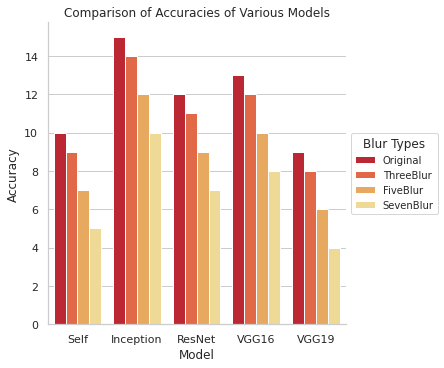

In [ ]:
# Comparison of Accuracies of all the models (Done).

# accuracy_df = pd.DataFrame(data=[{'Model':'Self', 'Original':10, 'ThreeBlur':9, 'FiveBlur':7, 'SevenBlur':5},{'Model':'Inception', 'Original':15, 'ThreeBlur':14, 'FiveBlur':12, 'SevenBlur':10},{'Model':'ResNet', 'Original':12, 'ThreeBlur':11, 'FiveBlur':9, 'SevenBlur':7},{'Model':'VGG16', 'Original':13, 'ThreeBlur':12, 'FiveBlur':10, 'SevenBlur':8},{'Model':'VGG19', 'Original':9, 'ThreeBlur':8, 'FiveBlur':6, 'SevenBlur':4}])
accuracy_df = pd.DataFrame(data=[{'Model':'Self', 'Original':self_acc_original, 'ThreeBlur':self_acc_3, 'FiveBlur':self_acc_5, 'SevenBlur':self_acc_7},{'Model':'Inception', 'Original':inception_acc_original, 'ThreeBlur':inception_acc_3, 'FiveBlur':inception_acc_5, 'SevenBlur':inception_acc_7},{'Model':'ResNet', 'Original':resnet_acc_original, 'ThreeBlur':resnet_acc_3, 'FiveBlur':resnet_acc_5, 'SevenBlur':resnet_acc_7},{'Model':'VGG16', 'Original':vgg16_acc_original, 'ThreeBlur':vgg16_acc_3, 'FiveBlur':vgg16_acc_5, 'SevenBlur':vgg16_acc_7},{'Model':'VGG19', 'Original':vgg19_acc_original, 'ThreeBlur':vgg19_acc_3, 'FiveBlur':vgg19_acc_5, 'SevenBlur':vgg19_acc_7}])
accuracy_df = pd.melt(accuracy_df, id_vars="Model", var_name="Blurs", value_name="Accuracy")

sns.set_style('whitegrid')
sns.catplot(x='Model', y='Accuracy', hue='Blurs', data=accuracy_df, kind='bar', palette='YlOrRd_r', legend=False)
plt.legend(title='Blur Types', fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Accuracies of Various Models')

plt.savefig(os.path.join(visualization_path, 'accuracy_comparison.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Comparison of Losses of all the models.

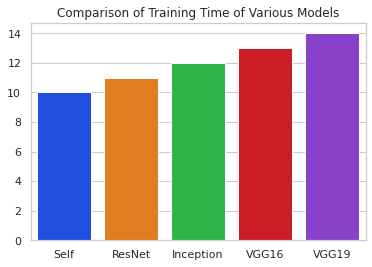

In [ ]:
# Comparison of Training time taken by each model (Done).

sns.set_style('whitegrid')
models = ['Self', 'ResNet', 'Inception', 'VGG16', 'VGG19']
time_values = [self_training_time, resnet_training_time, inception_training_time, vgg16_training_time, vgg19_training_time]
sns.barplot(y=time_values, x=models, palette='bright')
plt.title('Comparison of Training Time of Various Models')

plt.savefig(os.path.join(visualization_path, 'training_time_comparison.png'), dpi=300, bbox_inches='tight')

## Learning CNN



### Types of Padding in CNN.

In [ ]:
# Padding Full - Appending Zero to left and right of h.

x = [6, 2] 
h = [1, 2, 5, 4] 

y = np.convolve(x, h, "full") 
print(y) 

[ 6 14 34 34  8]


In [ ]:
# Padding Same - Appending Zero only to the left of h.

x = [6, 2] 
h = [1, 2, 5, 4] 

y = np.convolve(x, h, "same") 
print(y) 


[ 6 14 34 34]


In [ ]:
# Padding valid - No Zeros are appended.

x = [6, 2] 
h = [1, 2, 5, 4] 

y = np.convolve(x, h, "valid") 
print(y) 


[14 34 34]


### Optimizers

In [ ]:
# Gradient Decent.

In [ ]:
# Stochastic Gradient Descent.

In [ ]:
# Mini-batch Gradient Descent.

In [ ]:
# SGD + Momentum

In [ ]:
# SGD + Momentum + Acceleration

In [ ]:
# Adagrad

In [ ]:
# Adadelta

In [ ]:
# Adam

## Trying with 30,50 own dataset (Attempt Failed: Accuracy 49.5%).


In [ ]:
# thirty_path = "./30_50_OwnData/30/"
# fifty_path = "./30_50_OwnData/50/"

# mergedfiles_path = './30_50_OwnData/MergedFiles/'

mergedfiles_path = '/content/drive/My Drive/Colab Notebooks/Traffic Sign/MergedFiles'

In [ ]:
#Checking if the directory exists.
os.path.isdir(mergedfiles_path)

# Deleting the directory.
shutil.rmtree(mergedfiles_path)

In [ ]:
# Unzipping files to the directory as a fresh start.

%%time

!unzip '/content/drive/My Drive/Colab Notebooks/Traffic Sign/MergedFiles.zip' -d '/content/drive/My Drive/Colab Notebooks/Traffic Sign'

In [ ]:
# Activating GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Renamed images and moved to the train folder from 30 folder.
i = 1
for filename in glob.iglob(thirty_path + '*', recursive=True):
    filename = filename.replace("\\", "/")
    shutil.move(filename, mergedfiles_path+'thirty_{}.png'.format(i))
    i += 1

In [ ]:
# Renamed images and moved to the train folder from 50 folder.

i = 0
for filename in glob.iglob(fifty_path + '*', recursive=True):
    filename = filename.replace("\\", "/")
    shutil.move(filename, mergedfiles_path+'fifty_{}.png'.format(i))
    i += 1

In [ ]:
# listed the names of files in train folder.

all_files = os.listdir(mergedfiles_path)
len(all_files)

4470

In [ ]:
# Let's shuffle the list of all the files

random.shuffle(all_files)

In [ ]:
# function to read and process the images.

def read_process_images(filenames, width, height, path):
    X = []
    y = []
    count = 0
    for i in tq.tqdm(range(len(filenames))):
        img = cv2.imread(path+'/'+filenames[i], cv2.IMREAD_COLOR)
        X.append(cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC))
        # print(count)
        
        if 'thirty' in filenames[i]:
            y.append(1)
        elif 'fifty' in filenames[i]:
            y.append(0)
        else:
            y.append('')
        count += 1
    return X, y
    

In [ ]:
X, y = read_process_images(all_files, 75, 75, mergedfiles_path)

In [ ]:
X[0]

array([[[156, 142,  98],
        [186, 166, 134],
        [215, 191, 179],
        ...,
        [255, 255, 247],
        [255, 255, 244],
        [255, 255, 246]],

       [[122, 116,  76],
        [141, 136, 104],
        [172, 162, 144],
        ...,
        [176, 174, 167],
        [162, 162, 154],
        [154, 156, 148]],

       [[155, 144, 107],
        [155, 145, 112],
        [170, 156, 128],
        ...,
        [ 87,  86,  88],
        [ 79,  79,  81],
        [ 75,  76,  78]],

       ...,

       [[ 45,  47,  40],
        [ 35,  37,  33],
        [ 27,  29,  28],
        ...,
        [ 54,  60,  65],
        [ 51,  57,  64],
        [ 49,  55,  64]],

       [[ 41,  44,  36],
        [ 33,  36,  31],
        [ 27,  30,  29],
        ...,
        [ 54,  59,  64],
        [ 48,  54,  59],
        [ 48,  54,  60]],

       [[ 39,  43,  36],
        [ 32,  36,  32],
        [ 26,  30,  29],
        ...,
        [ 50,  54,  60],
        [ 50,  55,  61],
        [ 48,  54,  61]]

In [ ]:
y[0]

0

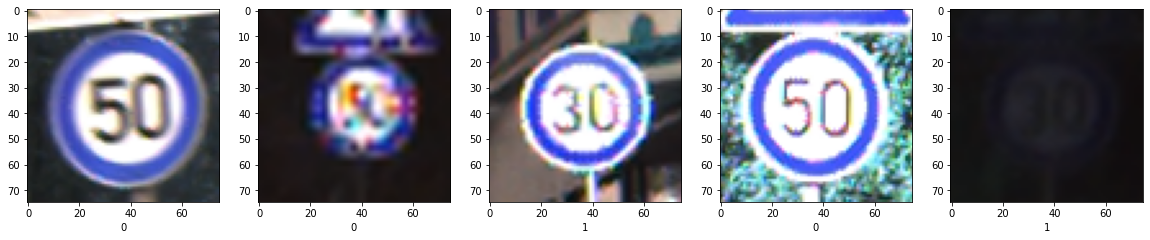

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i+1)
    plt.imshow(X[i])
    plt.xlabel(y[i])

In [ ]:
# Let's clear memory by deleting unnecessary variables.

del all_files

gc.collect()

11976

In [ ]:
# Let's check how many classes of images we have.

print("Thirty: ", y.count(1))
print("Fifty: ", y.count(0))
print("Other: ", y.count(''))

Thirty:  2220
Fifty:  2250
Other:  0


In [ ]:
# Let's convert lists to arrays and check the shape.

X = np.array(X)
y = np.array(y)

print("Shape of images is: ", X.shape)
print("Shape of lables is: ", y.shape)

Shape of images is:  (4470, 75, 75, 3)
Shape of lables is:  (4470,)


In [ ]:
# Let's separate 25% data for testing.

X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print("Information of Test Data")
print("")

print("Shape of images is: ", X_test.shape)
print("Shape of lables is: ", y_test.shape)
print("")

print("Thirty: ", list(y_test).count('T'))
print("Fifty: ", list(y_test).count('F'))
print("Other: ", list(y_test).count(''))

Information of Test Data

Shape of images is:  (1118, 75, 75, 3)
Shape of lables is:  (1118,)

Thirty:  0
Fifty:  0
Other:  0


In [ ]:
# Let's split X, y in train and validation subsets.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
print("Information of Train Data")
print("")

print("Shape of images is: ", X_train.shape)
print("Shape of lables is: ", y_train.shape)
print("")

print("Thirty: ", list(y_train).count('T'))
print("Fifty: ", list(y_train).count('F'))
print("Other: ", list(y_train).count(''))

Information of Train Data

Shape of images is:  (2849, 75, 75, 3)
Shape of lables is:  (2849,)

Thirty:  0
Fifty:  0
Other:  0


In [ ]:
print("Information of Validation Data")
print("")

print("Shape of images is: ", X_val.shape)
print("Shape of lables is: ", y_val.shape)
print("")

print("Thirty: ", list(y_val).count('T'))
print("Fifty: ", list(y_val).count('F'))
print("Other: ", list(y_val).count(''))

Information of Validation Data

Shape of images is:  (503, 75, 75, 3)
Shape of lables is:  (503,)

Thirty:  0
Fifty:  0
Other:  0


In [ ]:
# Let's clear some memory

del X
del y

gc.collect()

0

In [ ]:
# Length of train and validation set
ntrain = len(X_train)
nval = len(X_val)

# Let's consider the batch size as 32 for the model building.
batch_size = 32


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(75, 75, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-4), 
    metrics=['acc']
)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
#using ten epochs for the training and saving the accuracy for each epoch

history = model.fit(train_generator,
                    steps_per_epoch = ntrain // batch_size,
                    epochs= 128,
                    validation_data=val_generator,
                    validation_steps=nval // batch_size)

Epoch 1/128
89/89 [==============================] - 4s 46ms/step - loss: 0.2030 - acc: 0.9152 - val_loss: 0.1065 - val_acc: 0.9792
Epoch 2/128
89/89 [==============================] - 4s 45ms/step - loss: 0.1978 - acc: 0.9283 - val_loss: 0.0380 - val_acc: 0.9660
Epoch 3/128
89/89 [==============================] - 4s 45ms/step - loss: 0.1815 - acc: 0.9311 - val_loss: 0.0644 - val_acc: 0.9830
Epoch 4/128
89/89 [==============================] - 4s 44ms/step - loss: 0.1799 - acc: 0.9272 - val_loss: 0.0192 - val_acc: 0.9703
Epoch 5/128
89/89 [==============================] - 4s 44ms/step - loss: 0.1655 - acc: 0.9386 - val_loss: 0.1589 - val_acc: 0.9490
Epoch 6/128
89/89 [==============================] - 4s 45ms/step - loss: 0.1808 - acc: 0.9333 - val_loss: 0.0319 - val_acc: 0.9830
Epoch 7/128
89/89 [==============================] - 4s 46ms/step - loss: 0.1767 - acc: 0.9326 - val_loss: 0.0174 - val_acc: 0.9788
Epoch 8/128
89/89 [==============================] - 4s 44ms/step - loss: 0.

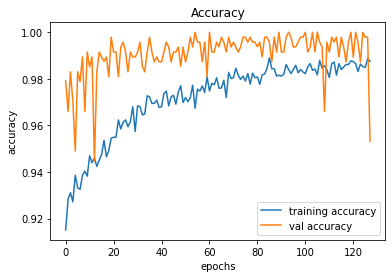

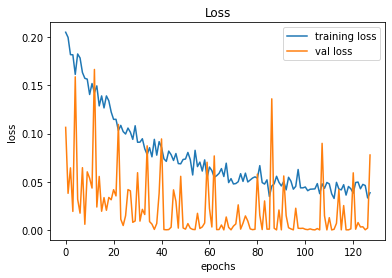

In [ ]:
# Display of the accuracy and the loss values

import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# Let's predict the test images.

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow(X_test, batch_size=1)

In [ ]:
i = 0
text_labels = []
# plt.figure(figsize=(30,20))

for i in tq.tqdm(range(len(test_generator))): 
  pred = model.predict(test_generator[i])
  if pred > 0.5:
    text_labels.append(0)
  else:
    text_labels.append(1)



In [ ]:
accuracy_score(y_test, text_labels)

0.49552772808586765